# Setup

## Load and install packages

In [1]:
# !pip install -U pypdfium2
# !pip install PyMuPDF
# !pip install -U nltk


In [2]:
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
from icecream import ic
import fitz
from PIL import Image

%matplotlib inline

## PDF Helper Functions

In [3]:

def get_pdf(path):
    '''Reads a PDF file and returns a PdfDocument object.'''
    doc = fitz.open(path)
    return doc

def render(page):
    '''Render a page to a PIL image.'''
    bitmap = page.render(
        scale = 1,    # 72dpi resolution
        rotation = 0, # no additional rotation
    )
    return bitmap.to_pil()

def extract_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the pdf
    page = doc[page_num] # select the page from the pdf
    content = page.get_text() # extract the text from the page
    return content

def render_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2]) # reconstruct the report name
    page_num = int(items[-1])-1
    
    # load pdf, select page, and render
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the report pdf
    dpi = 72   # set the dpi
    mat = fitz.Matrix(dpi / 72, dpi / 72)  # sets zoom factor
    pix = doc[page_num].get_pixmap(matrix=mat)
    img_page = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img_page

## Set path for folder

- choose one of the following blocks: online if run directly on Kaggle, local if data downloaded

In [4]:
# # kaggle online path
# basepath = "/kaggle/input/oxml2023mlcases-esg-classifier/data/"
# report_path = os.path.join(basepath, "reports")
# label_path = os.path.join(basepath, "labels.csv")

In [5]:
# local data path using pathlib

# main folder
basepath = '/Users/mbp14/Desktop/GoogleDrive/OxML_2023/code/Kaggle'

# build get path function, input folder name (as a list) and file name (optional), return the path
def get_path(folder_name: list, file_name=None):
    path = Path(basepath)
    for folder in folder_name:
        path = path / folder
    if file_name:
        path = path / file_name
    return path

# report path
report_path = get_path(["data", "reports"])

# label path
label_path = get_path(["data"], "labels.csv")


In [6]:

print("Report path: ", report_path)
print("Label path: ", label_path)

Report path:  /Users/mbp14/Desktop/GoogleDrive/OxML_2023/code/Kaggle/data/reports
Label path:  /Users/mbp14/Desktop/GoogleDrive/OxML_2023/code/Kaggle/data/labels.csv


# Load Data

In [7]:
# build path to data file in process folder
data_v1_path = get_path(["process"], "data_v1.parquet")

# load the file
df_eda = pd.read_parquet(data_v1_path)

In [8]:
df_eda.info()
df_eda.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1956 non-null   object
 1   report_name  1956 non-null   object
 2   page_num     1956 non-null   object
 3   class        1956 non-null   object
 4   tokens       1956 non-null   object
 5   num_tokens   1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


id  report_name page_num       class  \
0    report_519.pdf.53   report_519       53  governance   
1   report_1537.pdf.24  report_1537       24      social   
2    report_567.pdf.33   report_567       33  governance   
3  report_1830.pdf.220  report_1830      220       other   
4   report_1253.pdf.46  report_1253       46  governance   

                                              tokens  num_tokens  
0  [esg, impact, report, data, privacy, security,...         150  
1  [sustainability, report, table, content, socia...         167  
2  [sustainability, governance, clean, harbor, co...         203  
3  [report, viseur, entreprises, agr, evaluate, a...         299  
4  [pfizer, esg, report, governance, governance, ...         439

# EDA with tokens

In [9]:
# describe the distribution of number of tokens
df_eda['num_tokens'].describe()

count    1956.000000
mean      287.884458
std       154.528084
min         0.000000
25%       169.000000
50%       270.500000
75%       390.000000
max      1076.000000
Name: num_tokens, dtype: float64

In [10]:
# group by class and count the number of reports in each class
report_count = df_eda.groupby('class')['report_name'].nunique()

# make dictionary for color mapping of each class
color_dict = {'environmental': 'green', 'governance': 'orange','social': 'red', 'other': 'blue'}

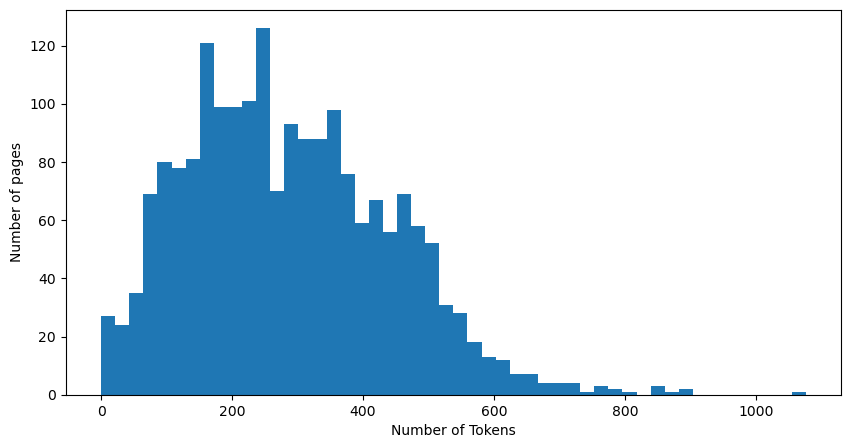

In [11]:
# plot the distribution of number of tokens using histogram
plt.figure(figsize=(10,5))
plt.xlabel('Number of Tokens')
plt.ylabel('Number of pages')
plt.hist(df_eda['num_tokens'], bins=50)
plt.show()

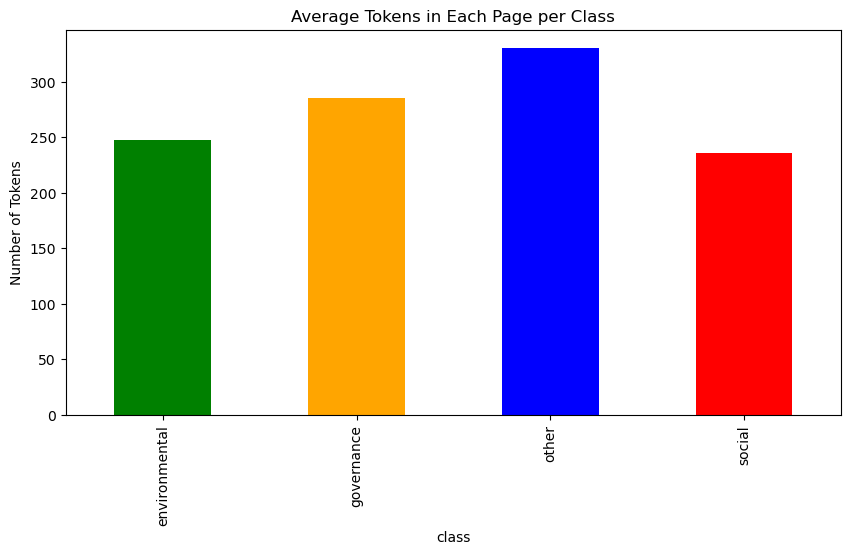

In [12]:
# plot the distribution of number of tokens for each class using bar plot
plt.figure(figsize=(10,5))
plt.xlabel('Class')
plt.ylabel('Number of Tokens')
df_ = df_eda.groupby('class')['num_tokens'].mean()
df_.plot(kind='bar', color=[color_dict[i] for i in df_.index])
plt.title('Average Tokens in Each Page per Class')
plt.show()

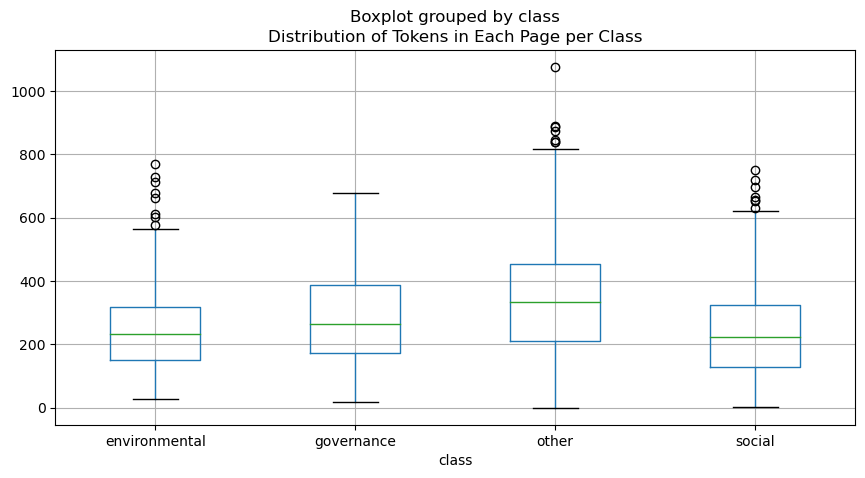

In [13]:
# plot the distribution of number of tokens for each class using  boxplot
df_eda.boxplot(column='num_tokens', by='class', figsize=(10,5))
plt.title('Distribution of Tokens in Each Page per Class')
plt.show()

## Pages with few tokens

In [14]:
# get the file id, class, and number of tokens, for the id with less than k tokens
min_token = 30 # set the threshold for number of tokens
df_few_tokens = df_eda[df_eda['num_tokens'] < min_token][['id', 'tokens','class', 'num_tokens']]

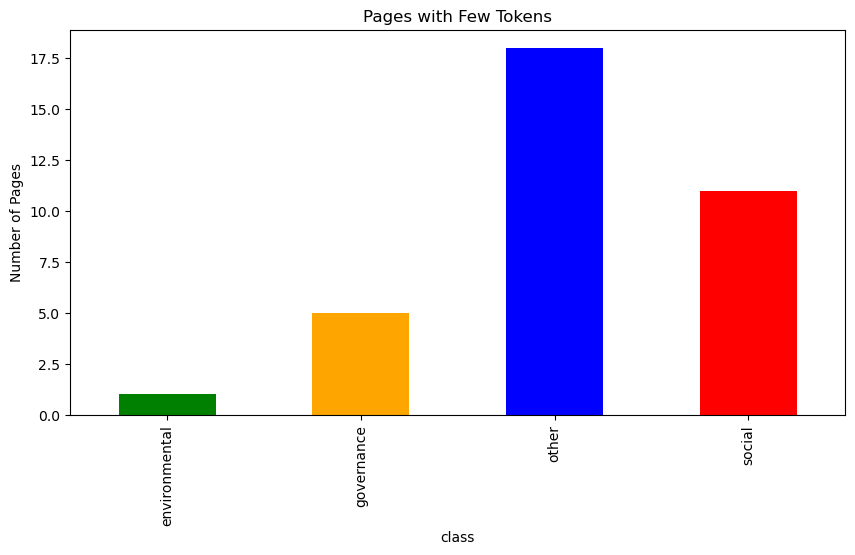

In [15]:
# pages with few token: plot distribution of frequency per class using bar plot
plt.figure(figsize=(10,5))
plt.xlabel('Class')
plt.ylabel('Number of Pages')
df_ = df_few_tokens.groupby('class')['num_tokens'].count()
df_.plot(kind='bar', color=[color_dict[i] for i in df_.index])
plt.title('Pages with Few Tokens')
plt.show()

ic| file_id: 'report_1826.pdf.55'
    tokens: array(['article', 'subject', 'audicom', 'talk', 'business'], dtype=object)
    label: 'other'


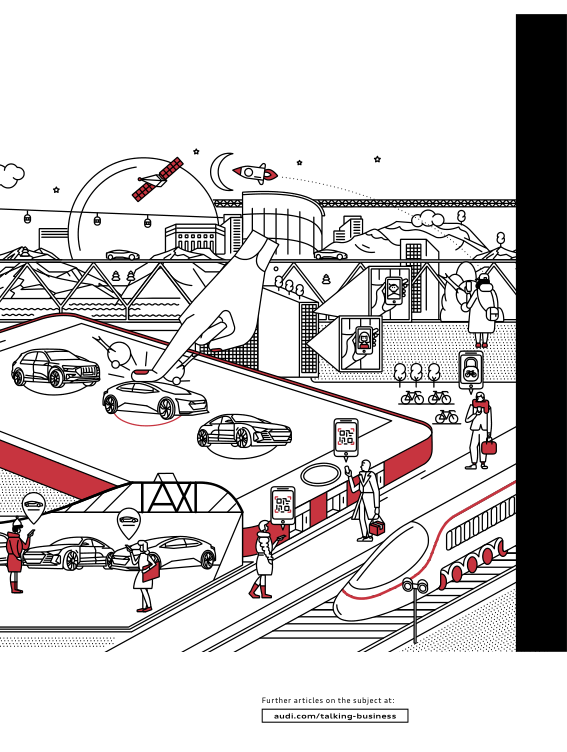

ic| file_id: 'report_810.pdf.14'
    tokens: array(['represent', 'foreign', 'nationals', 'worldwide', 'employ',
                   'people', 'dedicate', 'deliver', 'innovative', 'technologies',
                   'products', 'americas', 'employees', 'worldwide', 'people', 'asia',
                   'europe', 'represent', 'work', 'council', 'trade', 'union',
                   'workforce', 'demographics', 'fy', 'sustainability', 'report'],
                  dtype=object)
    label: 'social'


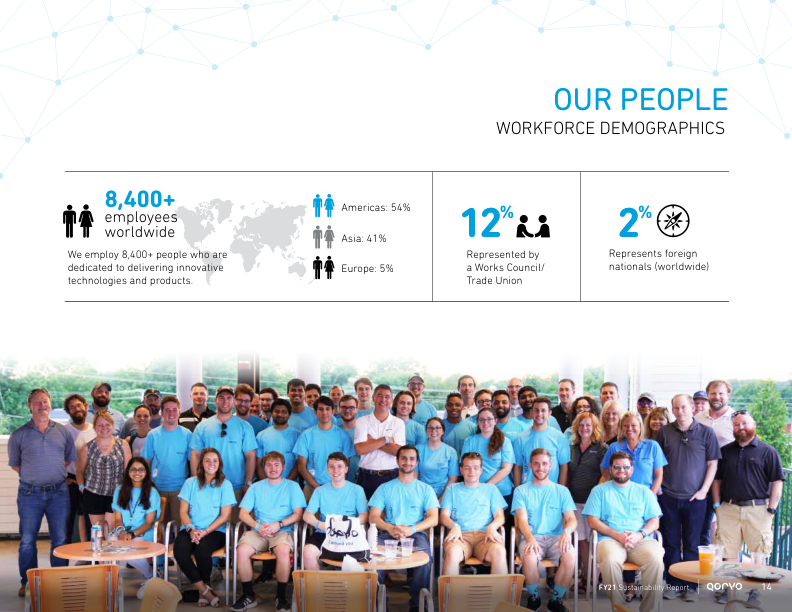

ic| file_id: 'report_833.pdf.50'
    tokens: array(['invest', 'communities'], dtype=object)
    label: 'social'


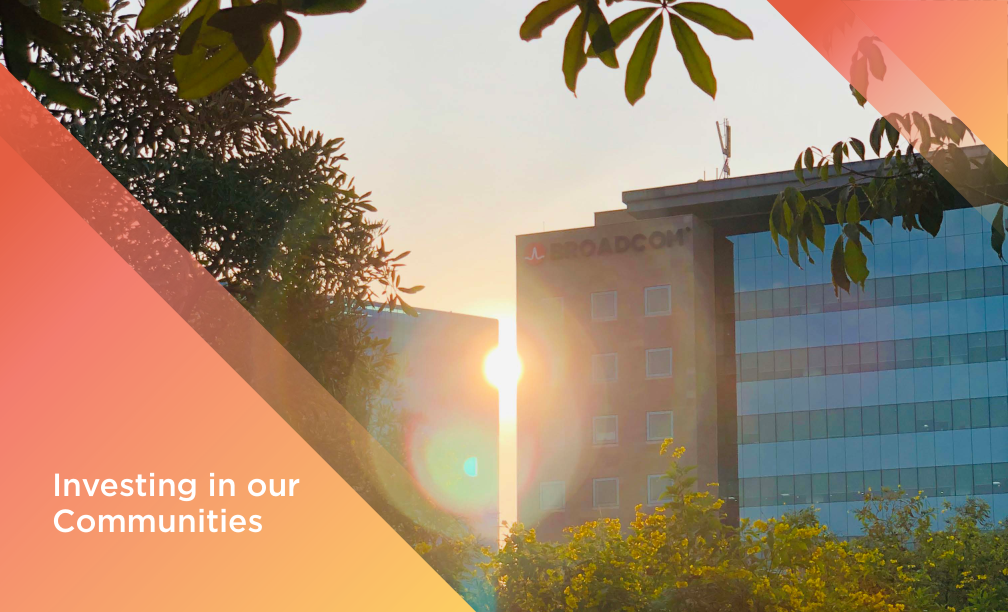

ic| file_id: 'report_279.pdf.17'
    tokens: array(['people', 'eopen', 'team', 'members', 'heart', 'company',
                   'diverse', 'inclusive', 'work', 'environment', 'support',
                   'ingenuity', 'creative', 'problem', 'solve', 'focus', 'right',
                   'business', 'communities', 'planet', 'people'], dtype=object)
    label: 'social'


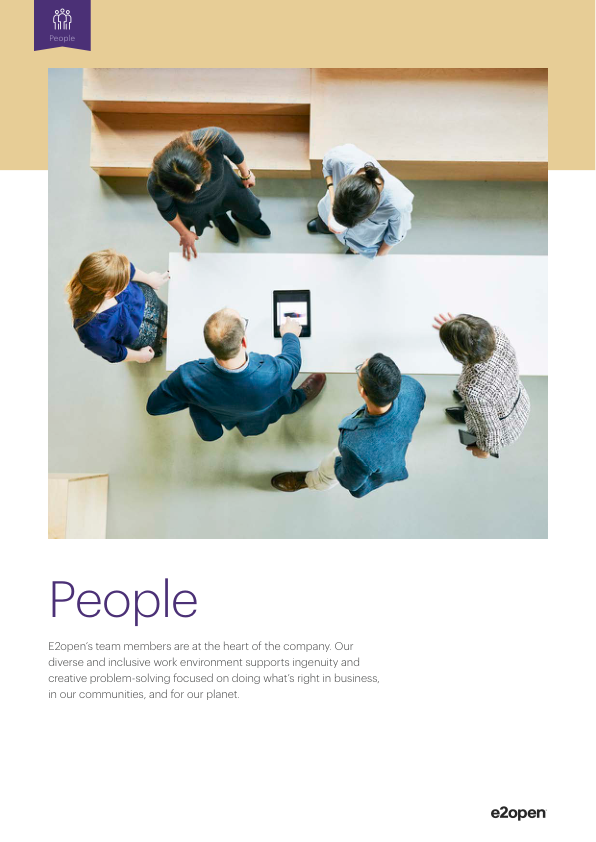

ic| file_id: 'report_1829.pdf.174'
    tokens: array(['information', 'annual', 'report', 'allianz', 'group', 'page',
                   'intentionally', 'leave', 'blank'], dtype=object)
    label: 'other'


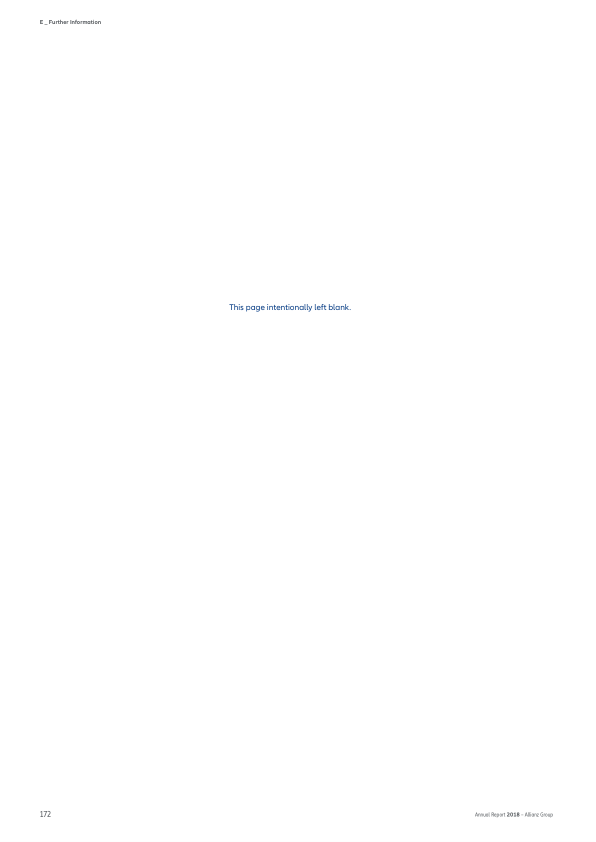

ic| file_id: 'report_1829.pdf.92'
    tokens: array(['group', 'management', 'report', 'annual', 'report', 'allianz',
                   'group', 'page', 'intentionally', 'leave', 'blank'], dtype=object)
    label: 'other'


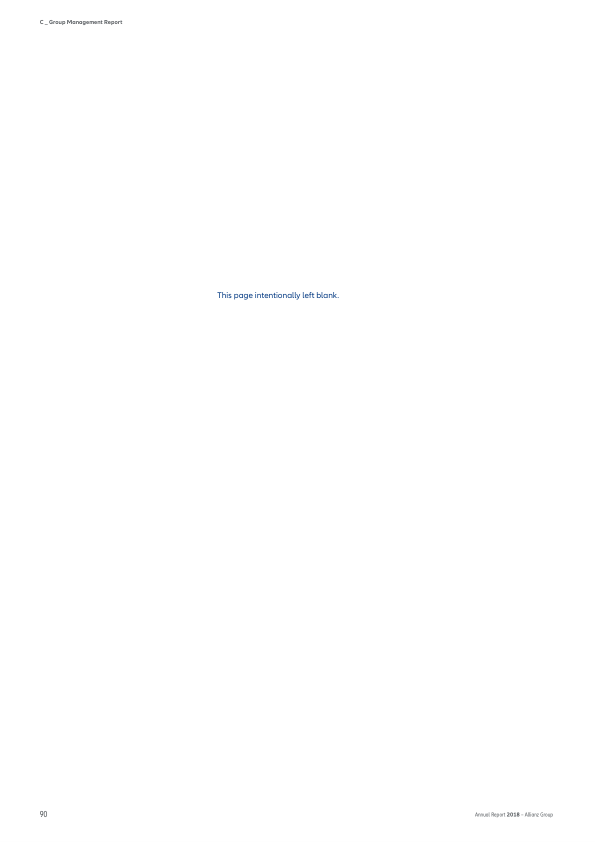

ic| file_id: 'report_1824.pdf.181'
    tokens: array(['reference', 'document', 'air', 'liquide', 'financial',
                   'statements'], dtype=object)
    label: 'other'


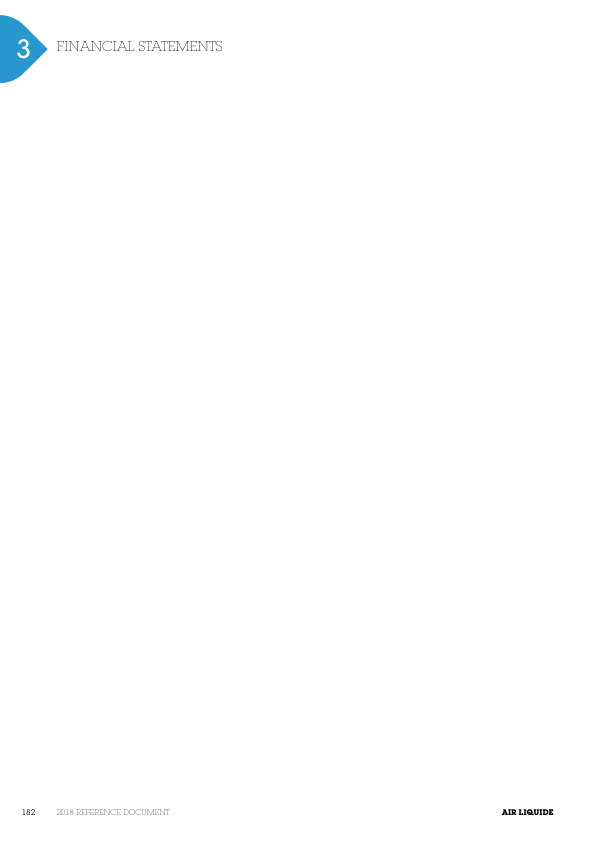

ic| file_id: 'report_1537.pdf.26'
    tokens: array(['sustainability', 'report', 'table', 'content', 'governance',
                   'table', 'content', 'governance', 'governance', 'hold',
                   'suppliers', 'partner', 'highest', 'ethical', 'standards', 'value',
                   'commitment', 'protect', 'people', 'environment', 'extend',
                   'innovation', 'principles', 'business', 'decisions', 'procurement',
                   'choices', 'sustainability', 'report'], dtype=object)
    label: 'governance'


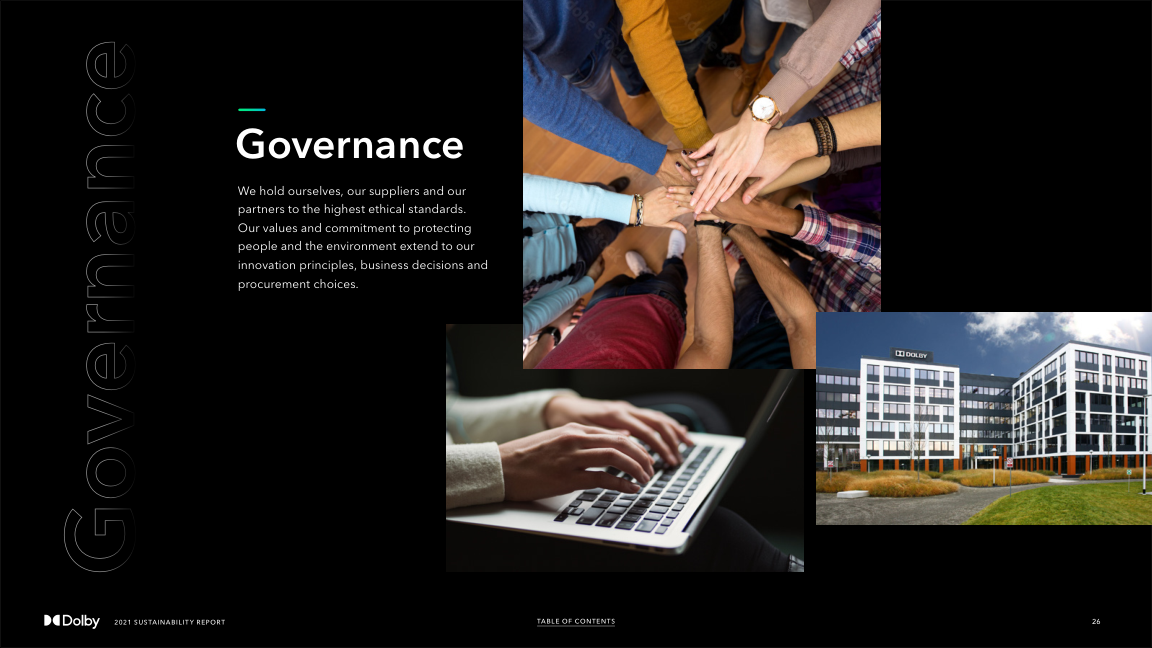

ic| file_id: 'report_751.pdf.41'
    tokens: array(['thrive', 'grow', 'together'], dtype=object)
    label: 'social'


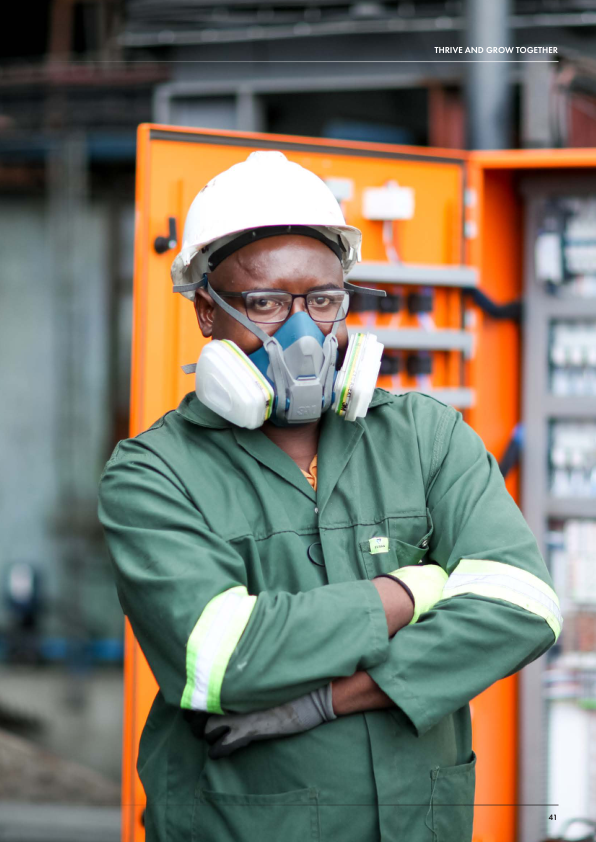

ic| file_id: 'report_1826.pdf.44'
    tokens: array(['really', 'like', 'display', 'set', 'audi', 'want', 'touch', 'try',
                   'everything', 'right', 'away', 'audi', 'virtual', 'cockpit',
                   'daniel', 'marr', 'pixels', 'audi', 'pixels', 'audi', 'audicom',
                   'talk', 'business', 'tech', 'experience'], dtype=object)
    label: 'other'


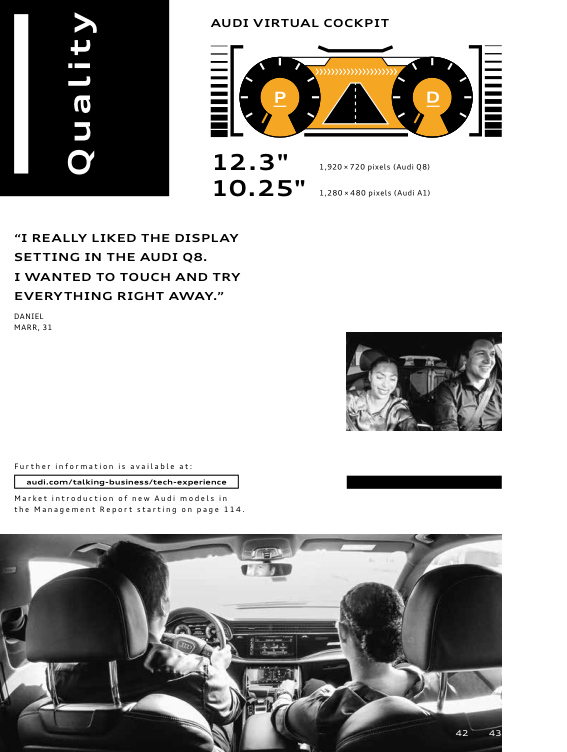

In [16]:
# get the file id, and render the pages with low tokens

# get a sample of 5 pages
sample_few_token = df_few_tokens.head(5)

# render pages
for idx, row in sample_few_token.iterrows():
    file_id, tokens, label = row['id'], row['tokens'], row['class']
    ic(file_id, tokens, label)        
    img = render_content_from_id(file_id)
    display(img)

In [17]:
# # strange pages if we use pypdfium2 to extract content
# file_id = 'report_1611.pdf.14'

# # extract content from the page
# strange_content = extract_content_from_id(file_id)
# strange_content

# content wasn't extracted properly
# rewrite the extract function using PyMuPDF: works Ok! 

In [18]:
# # check a few-token page
# file_id = 'report_1635.pdf.30'

# # extract content from the page
# test_content = extract_content_from_id(file_id)
# print(test_content)

# # render the page
# render_content_from_id(file_id)


## Token length analysis

In [19]:
# build a function: input is a series with tokens, oputput is the max length of tokens
def get_token_length(tokens):
  token_length = []
  if len(tokens) == 0:
    return 0
  else:
    for _,token in enumerate(tokens):
        token_length.append(len(token))
    max_length = max(token_length)
    return max_length
  

In [20]:
# use the function on the column of tokens
df_eda['max_len_token'] = df_eda['tokens'].apply(lambda row: get_token_length(row.ravel()))

### Pages with very long tokens

In [21]:
# slice df for rows with max_len_token > max_len
max_len = 20

df_long_token = df_eda[df_eda['max_len_token'] > max_len][['id', 'tokens','class', 'num_tokens', 'max_len_token']]

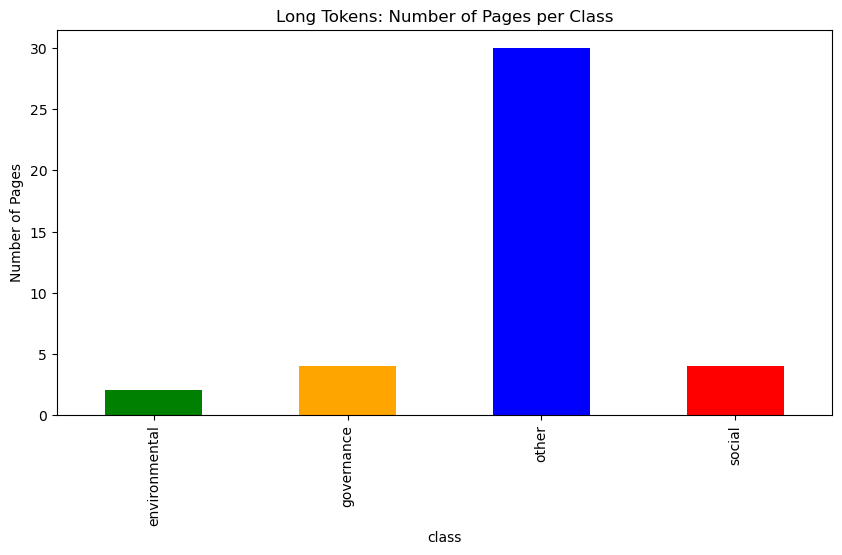

In [22]:
# plot distribution of frequency per class using bar plot
plt.figure(figsize=(10,5))
plt.xlabel('Class')
plt.ylabel('Number of Pages')
df_ = df_long_token.groupby('class')['id'].count()
df_.plot(kind='bar', color=[color_dict[i] for i in df_.index])
plt.title('Long Tokens: Number of Pages per Class')
plt.show()

ic| file_id: 'report_1829.pdf.157'
    tokens: array(['consolidate', 'financial',

 'statements', 'annual', 'report',
                   'allianz', 'group', 'repor', 'owned', 'azv', 'argos', 'verm',
                   'gensverwaltungsgesellschaft', 'mbh', 'munich', 'azv', 'argos',
                   'verm', 'gensverwaltungsgesellschaft', 'mbh', 'munich', 'azv',
                   'argos', 'verm', 'gensverwaltungsgesellschaft', 'mbh', 'munich',
                   'brahmsq', 'objekt', 'gmbh', 'co', 'kg', 'stuttgart', 'deutsche',
                   'lebensversicherungs', 'aktiengesellschaft', 'berlin', 'donator',
                   'beratungs', 'gmbh', 'munich', 'donator', 'beteiligungsverwaltung',
                   'gmbh', 'munich', 'euler', 'hermes', 'aktiengesellschaft',
                   'hamburg', 'euler', 'hermes', 'collections', 'gmbh', 'potsdam',
                   'euler', 'hermes', 'rat', 'deutschland', 'gmbh', 'hamburg', 'ga',
                   'global', 'automotive', 'versicherungsservice', 'gmbh', 'halle',
                   'saale', 'ids', 'gmbh', 'anal

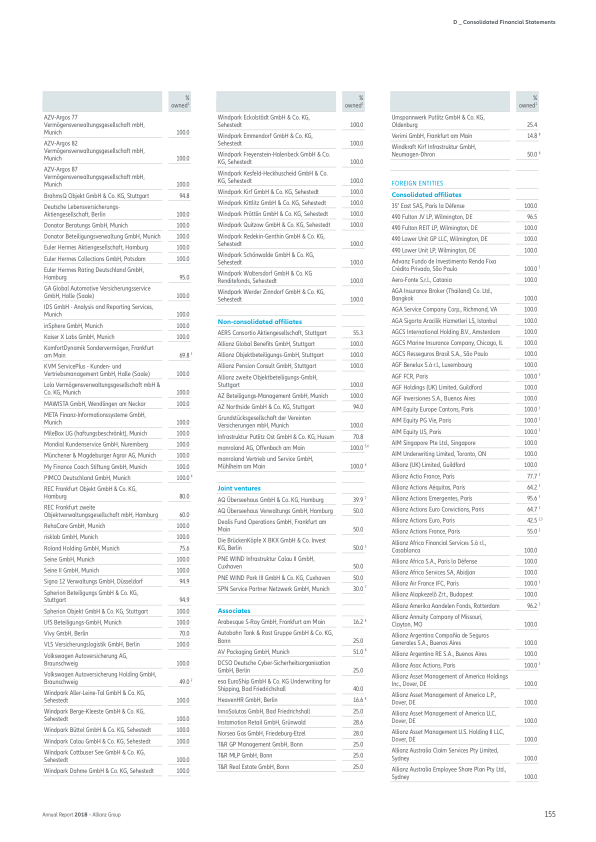

ic| file_id: 'report_519.pdf.54'
    tokens: array(['esg', 'impact', 'report', 'preview', 'storage', 'servers',
                   'eviews', 'tomge', 'service', 'prjnew', 'data', 'store', 'cm',
                   'yplod', 'thu', 'nk', 'block', 'storage', 'se', 'block', 'storose',
                   'servlco', 'fledata', 'store', 'encr', 'pted', 'block', 'preview',
                   'servers', 'pr', 'iii', 'proeosslflg', 'service', 'prev', 'ewdata',
                   'proc', 'essed', 'mtg', 'ryptc', 'chu', 'ii', 'ssutls', 'ssutls',
                   'metadata', 'databases', 'mctn', 'dj', 'hl', 'slorng', 'ct', 'lce',
                   'lj', 'rnformomnaboutyoulfslofedfle', 'sttkj', 'meet', 'servers',
                   'mol', 'dflto', 'procoming', 'sorvico', 'lnformat', 'jl', 'nbout',
                   'fl', 'proee', 'ed', 'lsu', 'fit', 'oome', 'type', 'multiple',
                   'oevice', 'data', 'privacy', 'security', 'reliability',
                   'governance', 'security', '

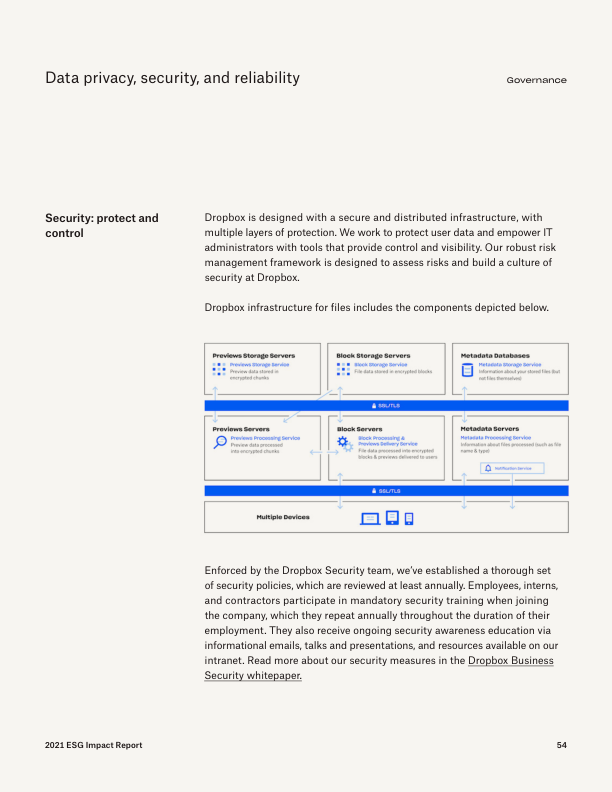

ic| file_id: 'report_932.pdf.36'
    tokens: array(['material', 'issue', 'supply', 'chain', 'continue', 'priority',
                   'also', 'give', 'produce', 'manufacture', 'firm', 'oppose',
                   'resellers', 'order', 'reduce', 'control', 'risk', 'suppliers',
                   'select', 'via', 'open', 'tender', 'process', 'include', 'assess',
                   'compliance', 'corporate', 'governance', 'principles', 'anti',
                   'corruption', 'policies', 'certain', 'suppliers', 'must', 'also',
                   'fill', 'prequalification', 'questionnaire', 'ethical',
                   'sustainability', 'conduct', 'monitor', 'suppliers', 'procurement',
                   'system', 'help', 'us', 'enforce', 'procurement', 'policy',
                   'apply', 'standards', 'consistently', 'across', 'large', 'number',
                   'contractors', 'additional', 'monitor', 'introduce', 'start',
                   'covid', 'pandemic', 'ensure', 'supply', '

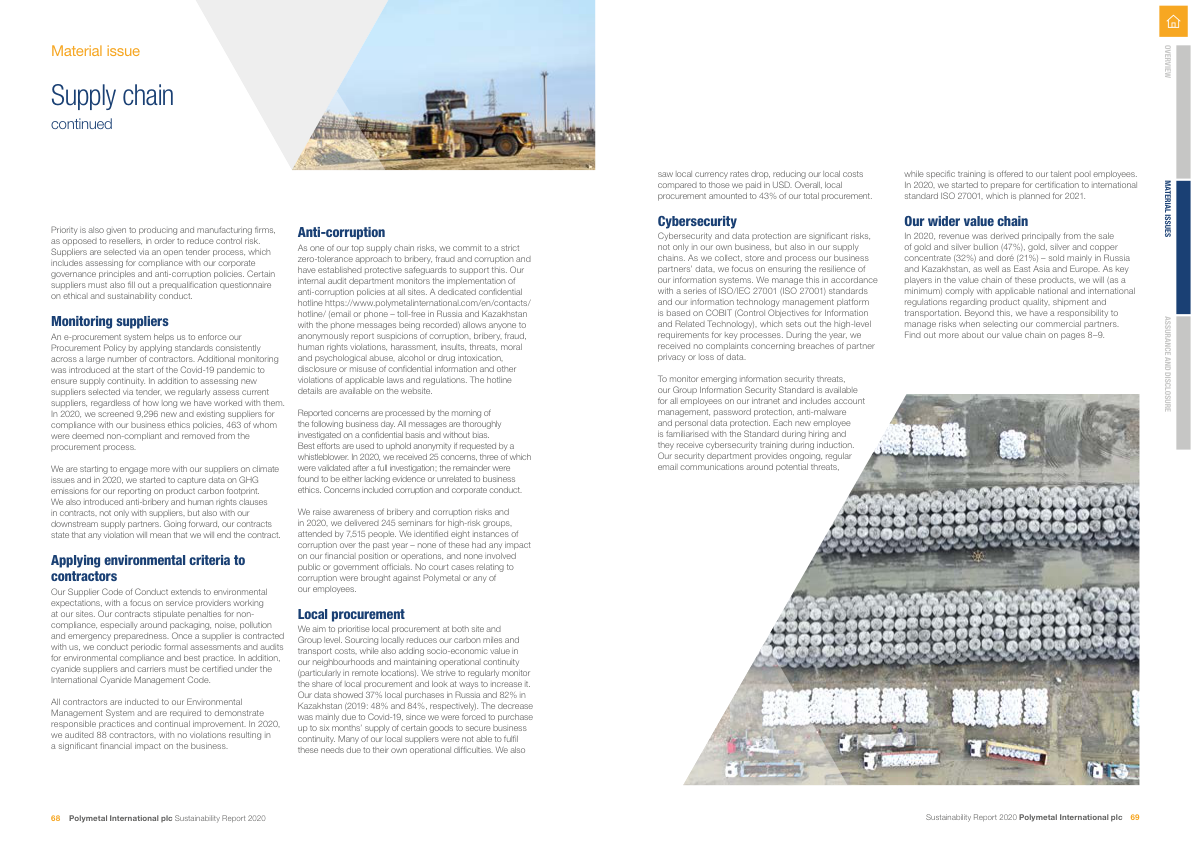

ic| file_id: 'report_1829.pdf.150'
    tokens: array(['consolidate', 'financial', 'statements', 'annual', 'report',
                   'allianz', 'group', 'commitments', 'contingencies', 'allianz',
                   'ht', 'fund', 'gmbh', 'sign', 'contingent', 'indemnity',
                   'agreement', 'july', 'pursuant', 'allianz', 'may', 'certain',
                   'circumstances', 'oblige', 'make', 'payments', 'ht', 'fund',
                   'gmbh', 'contingent', 'payment', 'obligation', 'allianz', 'relate',
                   'coupon', 'payments', 'tier', 'capital', 'securities', 'issue',
                   'ht', 'fund', 'gmbh', 'original', 'nominal', 'amount', 'tier',
                   'capital', 'securities', 'mn', 'reduce', 'approximately', 'mn',
                   'reduce', 'amount', 'coupon', 'payments', 'tier', 'capital',
                   'securities', 'contingent', 'payment', 'obligation', 'allianz',
                   'accordingly', 'since', 'june', 'annual', 'coupo

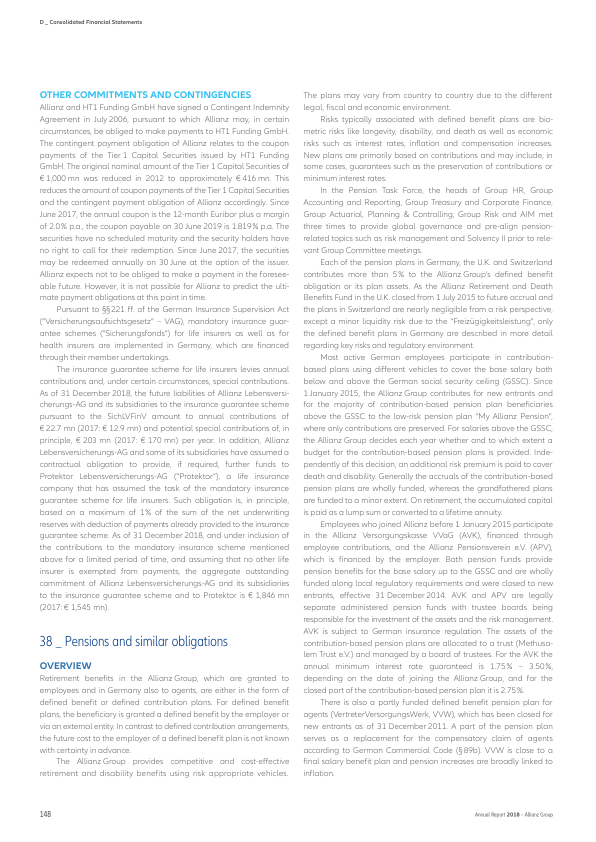

ic| file_id: 'report_1237.pdf.38'
    tokens: array(['sasb', 'reference', 'table', 'sustainability', 'account',
                   'standards', 'board', 'sasb', 'independent', 'organization', 'set',
                   'stand', 'ards', 'private', 'sector', 'purpose', 'improve',
                   'efficiency', 'capital', 'market', 'promot', 'ing', 'report',
                   'relevant', 'high', 'quality', 'sustainability', 'information',
                   'sasb', 'standards', 'allow', 'company', 'around', 'world',
                   'identify', 'manage', 'report', 'investors', 'material',
                   'financial', 'information', 'relate', 'sustainability', 'second',
                   'time', 'present', 'application', 'standards', 'sustainability',
                   'report', 'use', 'specific', 'sasb', 'standards', 'within', 'food',
                   'beverage', 'sector', 'industries', 'apply', 'operations',
                   'argentina', 'uruguay', 'agricultural', 'products'

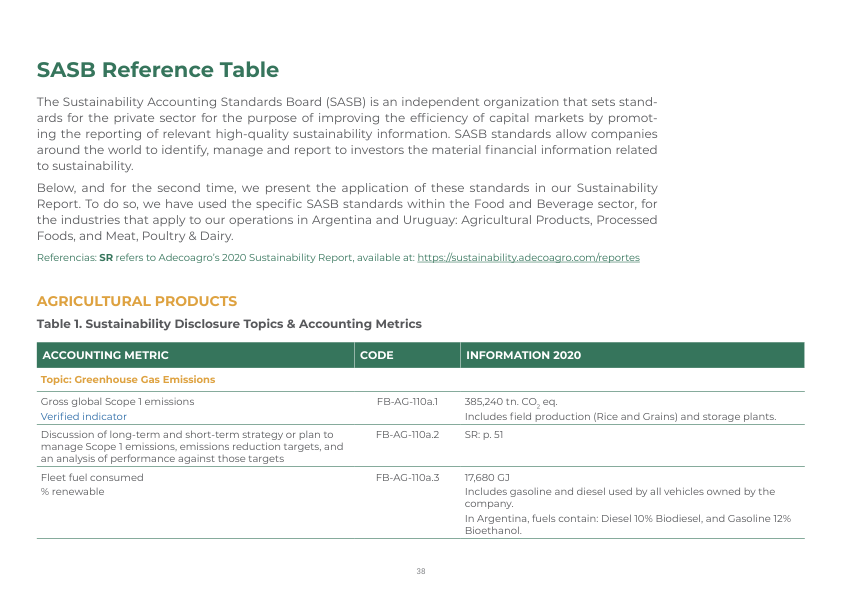

ic| file_id: 'report_1828.pdf.36'
    tokens: array(['deloitte', 'llp', 'assurance', 'deloitte', 'llp', 'provide',
                   'limit', 'assurance', 'follow', 'performance', 'indicators',
                   'group', 'level', 'diversity', 'total', 'employees', 'split',
                   'gender', 'age', 'ethics', 'employee', 'third', 'party',
                   'enquiries', 'ethics', 'officer', 'ethics', 'helpline', 'safety',
                   'recordable', 'accident', 'rate', 'number', 'major', 'injuries',
                   'record', 'number', 'fatalities', 'environment', 'greenhouse',
                   'gas', 'emissions', 'total', 'scope', 'community', 'total',
                   'value', 'community', 'investment', 'programme', 'donations',
                   'online', 'see', 'deloitte', 'llp', 'unqualified', 'assurance',
                   'statement', 'visit', 'baesystemscom',
                   'deloitteassurancestatement', 'see', 'basis', 'report', 'visit',
            

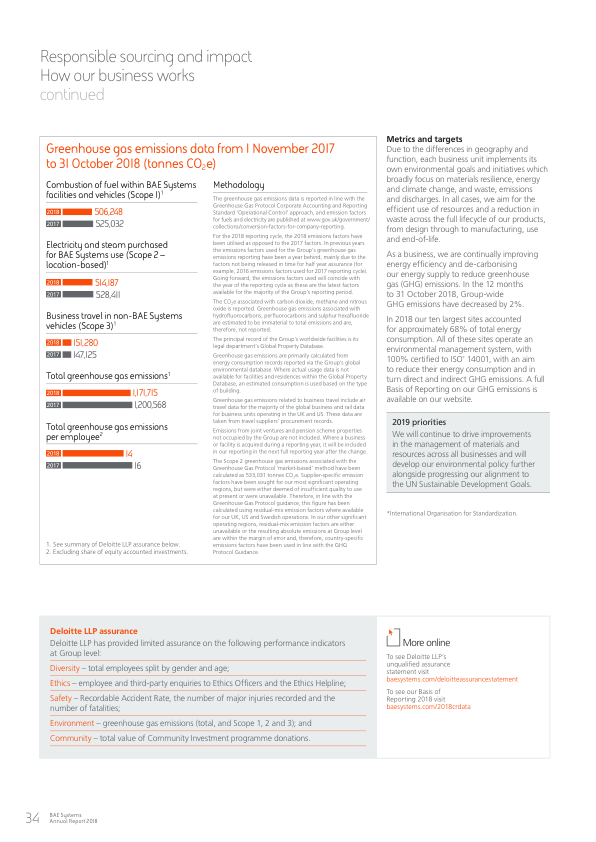

ic| file_id: 'report_932.pdf.34'
    tokens: array(['material', 'issue', 'communities', 'continue', 'local',
                   'employment', 'wherever', 'operate', 'strive', 'provide', 'local',
                   'people', 'job', 'opportunities', 'work', 'closely', 'local',
                   'colleges', 'institutions', 'provide', 'train', 'development',
                   'opportunities', 'communities', 'example', 'partner', 'local',
                   'technical', 'vocational', 'institutions', 'kazakhstan',
                   'proskills', 'global', 'european', 'bank', 'reconstruction',
                   'development', 'initiative', 'help', 'young', 'people', 'develop',
                   'mine', 'skills', 'uncertain', 'time', 'support', 'fund',
                   'occupational', 'health', 'safety', 'course', 'virtual', 'person',
                   'cover', 'international', 'best', 'practice', 'diagnostics',
                   'five', 'whys', 'analysis', 'hierarchy', 'risk', 'contro

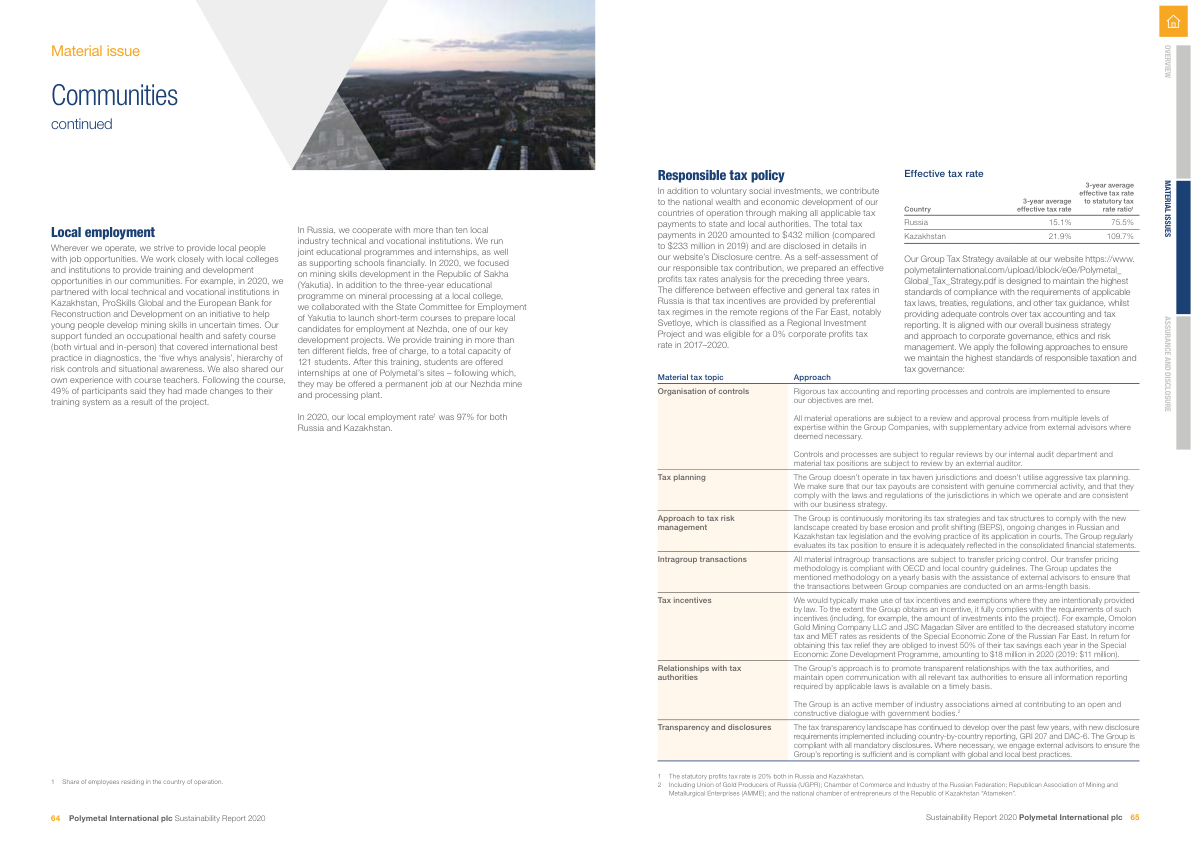

ic| file_id: 'report_1824.pdf.287'
    tokens: array(['environmental', 'societal', 'report', 'societal', 'achievements',
                   'air', 'liquide', 'foundation', 'create', 'air', 'liquide',
                   'foundation', 'represent', 'group', 'commitment', 'responsible',
                   'enterprise', 'air', 'liquide', 'foundation', 'provide',
                   'financial', 'material', 'human', 'resources', 'mean', 'project',
                   'support', 'countries', 'group', 'present', 'action', 'line',
                   'group', 'sustainable', 'development', 'strategy', 'aim',
                   'improve', 'air', 'quality', 'prevent', 'global', 'warm',
                   'strengthen', 'commitment', 'stakeholders', 'missions', 'include',
                   'environment', 'support', 'scientific', 'research', 'project',
                   'environmental', 'protection', 'field', 'contribute', 'preserve',
                   'planet', 'atmosphere', 'particular', 'air', 'qu

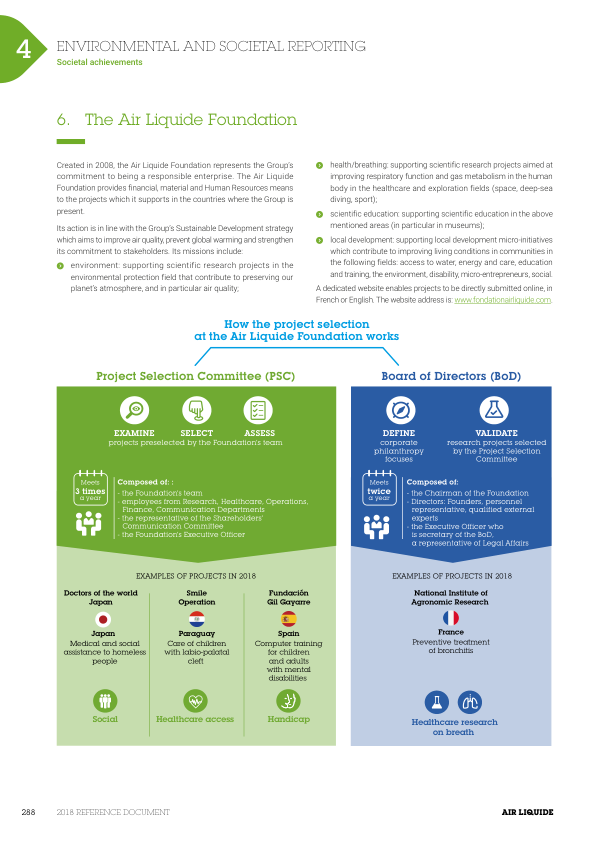

ic| file_id: 'report_1829.pdf.161'
    tokens: array(['consolidate', 'financial', 'statements', 'annual', 'report',
                   'allianz', 'group', 'repor', 'owned', 'beykoz', 'gayrimenkul',
                   'yatirim', 'insaat', 'turizm', 'sanayi', 'ticaret', 'as', 'ankara',
                   'bilan', 'service', 'snc', 'nanterre', 'biuro', 'informacji',
                   'gospodarczej', 'euler', 'hermes', 'sa', 'warsaw', 'borgo', 'san',
                   'felice', 'srl', 'castelnuovo', 'berardenga', 'bps', 'brindisi',
                   'srl', 'lecce', 'bps', 'brindisi', 'srl', 'lecce', 'bps',
                   'brindisi', 'srl', 'lecce', 'bps', 'mesagne', 'srl', 'lecce',
                   'bps', 'mesagne', 'srl', 'lecce', 'bps', 'mesagne', 'srl', 'lecce',
                   'bps', 'mesagne', 'srl', 'lecce', 'bps', 'mesagne', 'srl', 'lecce',
                   'brasil', 'de', 'im', 'veis', 'participa', 'es', 'ltda', 'paulo',
                   'bravo', 'ii', 'civ', 'llc',

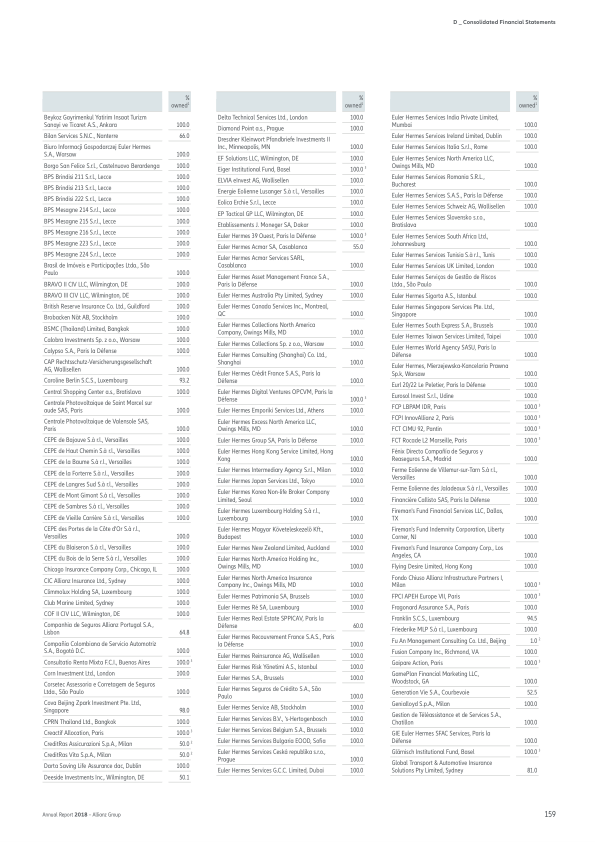

ic| file_id: 'report_810.pdf.10'
    tokens: array(['hold', 'suppliers', 'high', 'standards', 'require', 'customers',
                   'responsible', 'business', 'alliance', 'rba', 'regular',
                   'engagements', 'supply', 'chain', 'assessments', 'train',
                   'opportunities', 'take', 'affirmative', 'step', 'ensure',
                   'suppliers', 'understand', 'qorvo', 'expectations', 'maintain',
                   'socially', 'responsible', 'supply', 'chain', 'qorvo',
                   'management', 'system', 'align', 'rba', 'code', 'conduct',
                   'utilize', 'tool', 'rba', 'saq', 'conduct', 'supply', 'chain',
                   'assessments', 'mitigate', 'potential', 'risk', 'strategic',
                   'suppliers', 'request', 'complete', 'third', 'party', 'audits',
                   'review', 'compliance', 'rba', 'code', 'also', 'utilize', 'rba',
                   'resources', 'elearning', 'platform', 'rba', 'data', 'analytics',
   

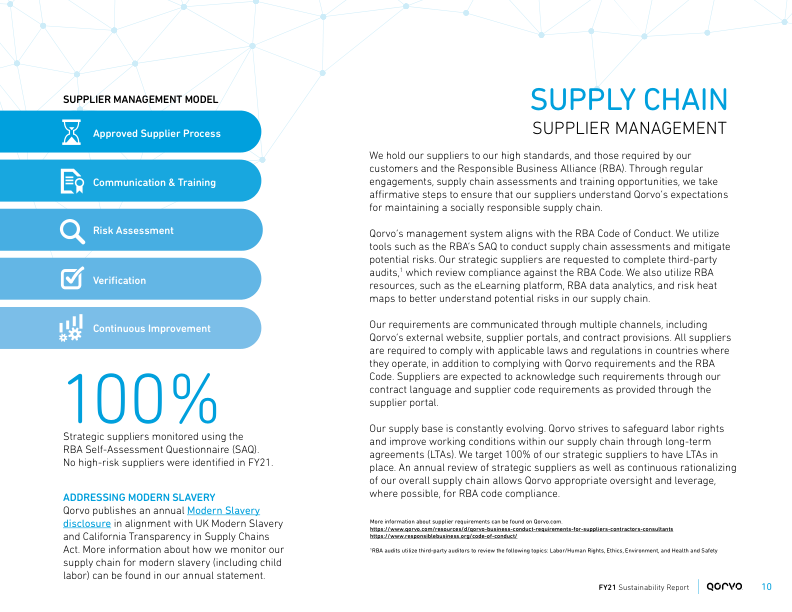

In [23]:
# long tokens: get a sample and render the pages
sample_long_token = df_long_token.sort_values(by='max_len_token', ascending=False).head(5)

for idx, row in sample_long_token.iterrows():
    file_id, tokens, label = row['id'], row['tokens'], row['class']
    ic(file_id, tokens, label)        
    img = render_content_from_id(file_id)
    display(img)

### Pages with high ratio of short tokens 
- token len = 2: indicative of parsing difficulties

In [24]:
# make function: input is a series with tokens, oputput is the total number of tokens with length < 3
def get_short_token(tokens):
  short_token = []
  if len(tokens) == 0:
    return 0
  else:
    for _,token in enumerate(tokens):
      # if the token length is less than k, append it to the list
      if len(token) <= 2:
        short_token.append(token)
    return len(short_token)/len(tokens)

In [25]:
# use the function on the column of tokens
df_eda['ratio_short_token'] = df_eda['tokens'].apply(lambda row: get_short_token(row.ravel()))

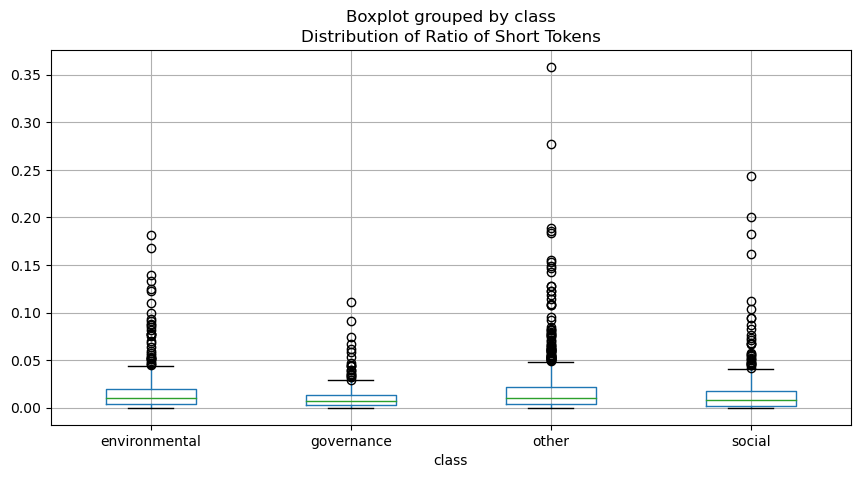

In [26]:
# plot distribution of ratio of short tokens using boxplot
df_eda.boxplot(column='ratio_short_token', by = 'class', figsize=(10,5))
plt.title('Distribution of Ratio of Short Tokens')
plt.show()

In [27]:
# identify the 90 percentile ratio of short tokens
ratio = df_eda['ratio_short_token'].quantile(0.90)
ic(ratio)

# slice df for rows with ratio_short_token > ratio
df_short_token = df_eda[df_eda['ratio_short_token'] > ratio][['id', 'tokens','class', 'num_tokens', 'ratio_short_token']]

ic| ratio: 0.03803496081977095


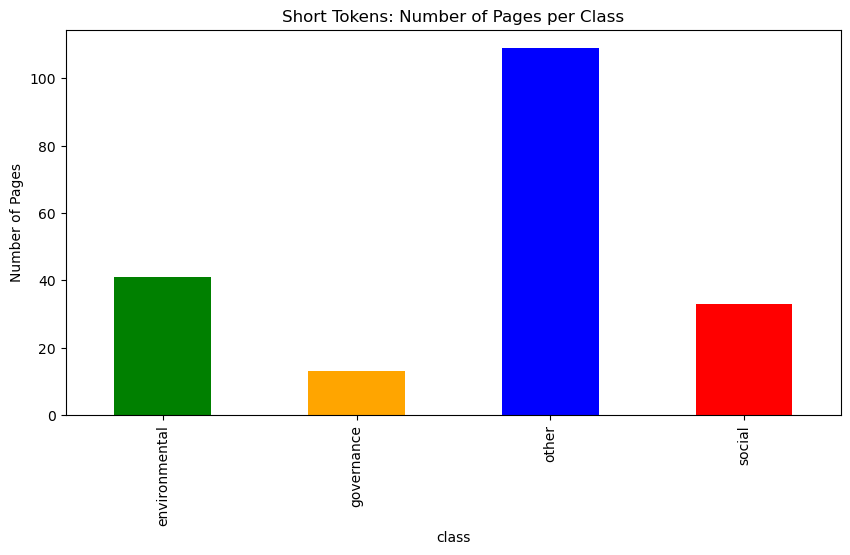

In [28]:
# plot distribution of frequency per class using bar plot
plt.figure(figsize=(10,5))
plt.xlabel('Class')
plt.ylabel('Number of Pages')
df_ = df_short_token.groupby('class')['id'].count()
df_.plot(kind='bar', color=[color_dict[i] for i in df_.index])
plt.title('Short Tokens: Number of Pages per Class')
plt.show()

ic| file_id

: 'report_1825.pdf.142'
    tokens: array(['corporate', 'governance', 'executive', 'compensation', 'share',
                   'ownership', 'date', 'shareholders', 'meet', 'grant', 'date',
                   'board', 'directors', 'management', 'board', 'total', 'number',
                   'beneficiaries', 'total', 'number', 'share', 'subscribe',
                   'purchase', 'subscribe', 'purchase', 'corporate', 'icers',
                   'thomas', 'buberl', 'denis', 'duverne', 'doina', 'palici',
                   'chehab', 'first', 'employees', 'beneficiaries', 'start', 'date',
                   'exercise', 'expiry', 'date', 'options', 'subscription',
                   'purchase', 'price', 'options', 'exercise', 'schedule', 'options',
                   'af', 'er', 'af', 'er', 'af', 'er', 'af', 'er', 'af', 'er', 'af',
                   'er', 'af', 'er', 'af', 'er', 'af', 'er', 'af', 'er', 'af', 'er',
                   'af', 'er', 'af', 'er', 'af', 'er', 'af', 'er', 'af', 'er',

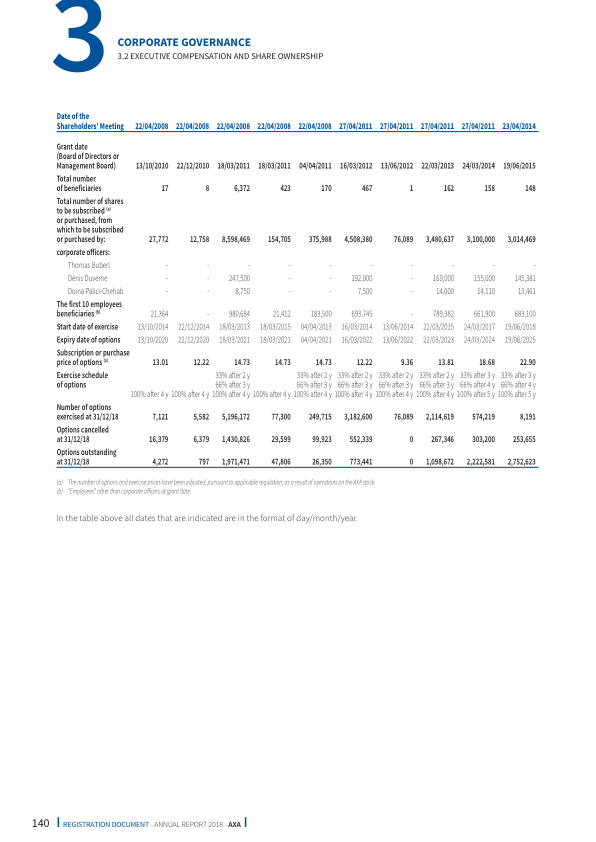

ic| file_id: 'report_1825.pdf.11'
    tokens: array(['business', 'model', 'resources', 'investors', 'bn',
                   'shareholders', 'equity', 'employees', 'salaried', 'employees',
                   'average', 'ftes', 'customers', 'bn', 'gross', 'write', 'premiums',
                   'governements', 'regulators', 'solvency', 'ii', 'ratio', 'create',
                   'products', 'service', 'enable', 'customers', 'transfer', 'risk',
                   'return', 'pay', 'us', 'contributions', 'premiums', 'deposit',
                   'invest', 'future', 'identify', 'evaluate', 'pool', 'risk',
                   'people', 'property', 'assets', 'stable', 'society', 'help',
                   'customers', 'reduce', 'risk', 'commit', 'customers', 'partner',
                   'investors', 'reinvesting', 'part', 'profit', 'business', 'human',
                   'resources', 'communities', 'generate', 'profit', 'insurance',
                   'business', 'invest', 'behalf', 'company'

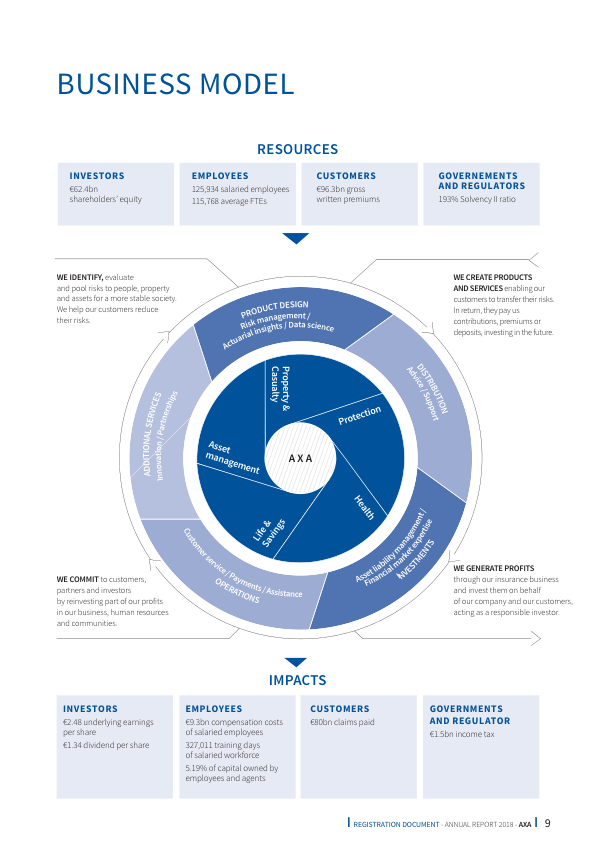

ic| file_id: 'report_711.pdf.84'
    tokens: array(['people', 'central', 'pillar', 'labour', 'intensive', 'mine',
                   'business', 'without', 'exxaro', 'thrive', 'sustainability',
                   'productivity', 'inextricably', 'link', 'holistic', 'wellbeing',
                   'dedicate', 'protect', 'safety', 'health', 'wellbeing', 'personal',
                   'development', 'need', 'expectations', 'people', 'uphold',
                   'licence', 'operate', 'people', 'diversity', 'inclusion',
                   'strategies', 'alignment', 'commitment', 'internal', 'policies',
                   'employee', 'value', 'proposition', 'evp', 'inspire', 'people',
                   'guide', 'toward', 'meaningful', 'purpose', 'create', 'new',
                   'opportunities', 'appreciate', 'change', 'inevitable', 'approach',
                   'people', 'partner', 'capabilities', 'mindset', 'environment',
                   'passion', 'achieve', 'purpose', 'company', 'b

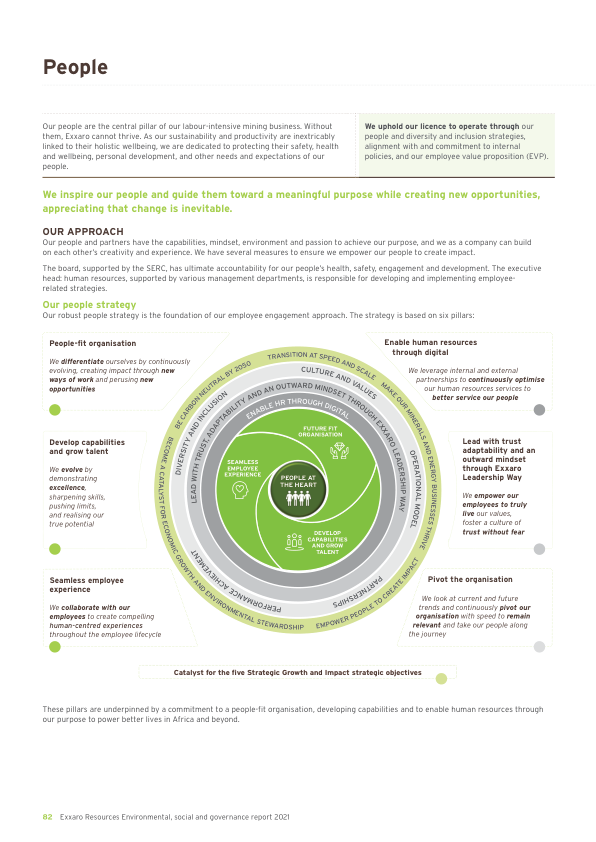

ic| file_id: 'report_810.pdf.9'
    tokens: array(['supply', 'chain', 'fy', 'sustainability', 'report'], dtype=object)
    label: 'social'


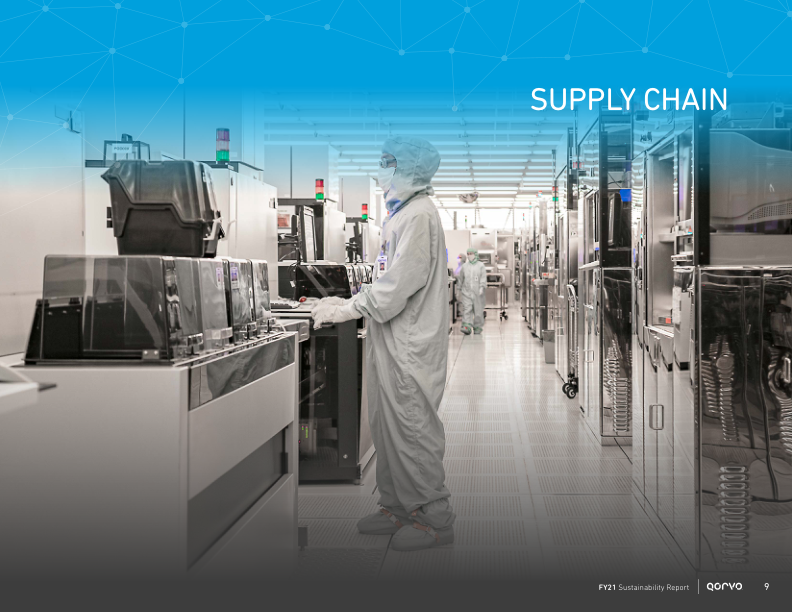

ic| file_id: 'report_1833.pdf.202'
    tokens: array(['anglo', 'american', 'plc', 'integrate', 'annual', 'report',
                   'financial', 'statements', 'financial', 'information', 'exchange',
                   'rat', 'commodity', 'price', 'us', 'exchange', 'rat', 'year',
                   'end', 'spot', 'rat', 'south', 'african', 'rand', 'brazilian',
                   'real', 'sterling', 'australian', 'dollar', 'euro', 'chilean',
                   'peso', 'botswana', 'pula', 'average', 'rat', 'year', 'south',
                   'african', 'rand', 'brazilian', 'real', 'sterling', 'australian',
                   'dollar', 'euro', 'chilean', 'peso', 'botswana', 'pula',
                   'commodity', 'price', 'year', 'end', 'spot', 'price', 'copper',
                   'us', 'cents', 'lb', 'platinum', 'us', 'oz', 'palladium', 'us',
                   'oz', 'rhodium', 'us', 'oz', 'iron', 'ore', 'fe', 'cfr', 'us',
                   'tonne', 'iron', 'ore', 'fe', 'concentrate',

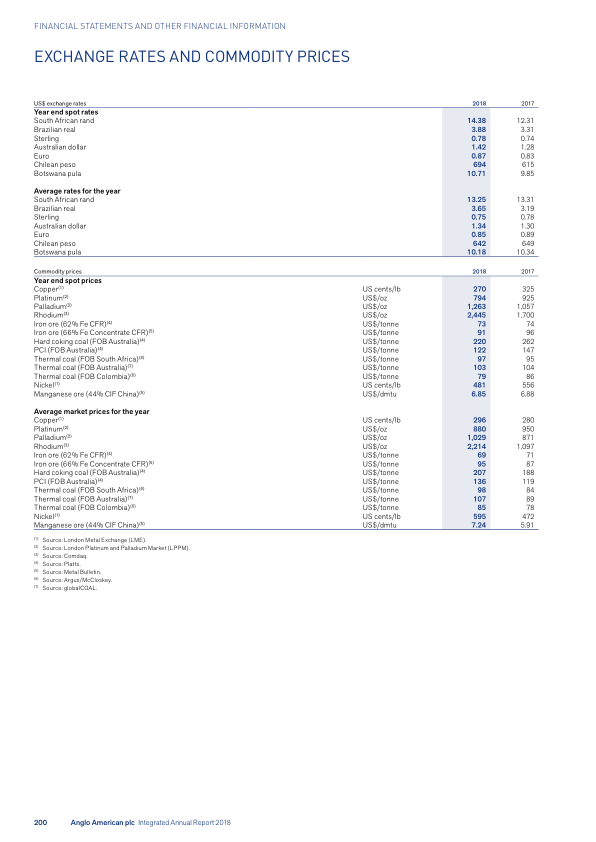

In [29]:
# render the pages with high ratio of short tokens

# sample rows with high ratio of short tokens
sample_short_token = df_short_token.sort_values(by='ratio_short_token', ascending=False).head(5)

for idx, row in sample_short_token.iterrows():
    file_id, tokens, label = row['id'], row['tokens'], row['class']
    ic(file_id, tokens, label)        
    img = render_content_from_id(file_id)
    display(img)

## Insights from tokens EDA

- few tokens: pages with no text
  - cover or blank
  - begin/end of chapters

<!-- -->
 
- very long tokens come from parsing special elements: more often in 'other'
  - broken: text in box, hyperlink, footnotes
  - involves unrecognizable character `char(65533)`
  - special words (names, german, etc.)


 <!-- -->
 
- short tokens come from parsing graphs and tables
  - empty: 'na'
  - unit: 'co', 'us', 'kg'
  - broken words


 <!-- -->


In [30]:
# export samples dfs to csv files, keeping only the id and class columns
sample_few_token[['id', 'class']].to_csv(get_path(["process"], "sample_few_token.csv"), index=False)
sample_long_token[['id', 'class']].to_csv(get_path(["process"], "sample_long_token.csv"), index=False)
sample_short_token[['id', 'class']].to_csv(get_path(["process"], "sample_short_token.csv"), index=False)


### *Main ideas*

- no text: images, tables, charts -> need CV
- text blended: de-noise content, targeted parsing, NLP
  - OCR corner, or margin box
- mostly text: NLP